# Introduction

1. Visualization of the recordings - input features

```
1.1. wave and spectrogram
1.2. MFCC
1.3. Spectrogram in 3d
1.4. Silenece removal
1.5. Resampling - dimensionality reductions
1.6. Features extraction steps
```

2. Dataset investigation

```
2.1. Number of files
2.2. Mean spectrograms and fft
2.3. Deeper into recordings
2.4. Length of recordings
2.5. Note on Gaussian Mixtures modeling
2.6. Frequency components across the words
2.7. Anomaly detection
```
3. Where to look for the inspiration

All we need is here:


In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Visualization

There are two theories of a human hearing - place(
https://en.wikipedia.org/wiki/Place_theory_(hearing)(frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing)) In speech recognition, I see two main tendencies -  to input spectogram, and more sophisticated features MFCC(Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

# 1.1 Wave and Spectrogram:
choose and read some file:

[MFCC에 대한 이해](https://brightwon.tistory.com/11)


In [4]:
!pip install py7zr
import py7zr
import os

input_path = '/kaggle/input/tensorflow-speech-recognition-challenge/train.7z'
output_path = '/kaggle/working/'

# 압축 해제
with py7zr.SevenZipFile(input_path, mode='r') as z:
    z.extractall(path=output_path)

# 압축 해제된 파일 목록 확인
extracted_files = os.listdir(output_path)
print(extracted_files)


['train', '.virtual_documents']


In [7]:
train_audio_path = '/kaggle/working/train/audio'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values.
It will make out plot much more clear, moreover, it is strictly connected to the
way people hear. We need to assure that there are no 0 values as input to logarithm.

```
스펙트로그램을 계산하는 함수를 정의한다.
스펙트로그램의 값은 로그를 취하고 그것은 plot을 훨씬 정확하게 해준다.
덧붙혀서 사람들이 듣는 방식과 더 강하게 연결되어 있다.
로그에 대한 입력값은 0이 될 수 없다.
```

In [12]:
def log_specgram(audio, sample_rate, window_size=20,
                step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                           fs =sample_rate,
                                           window = 'hann',
                                           nperseg = nperseg,
                                           noverlap = noverlap,
                                           detrend =  False)
    return freqs, times, np.log(spec.T.astype(np.float32)+eps)

Frequencies are in rane(0,8000) according to Nyquist theorem.
Let's plot it:

Text(0.5, 0, 'Seconds')

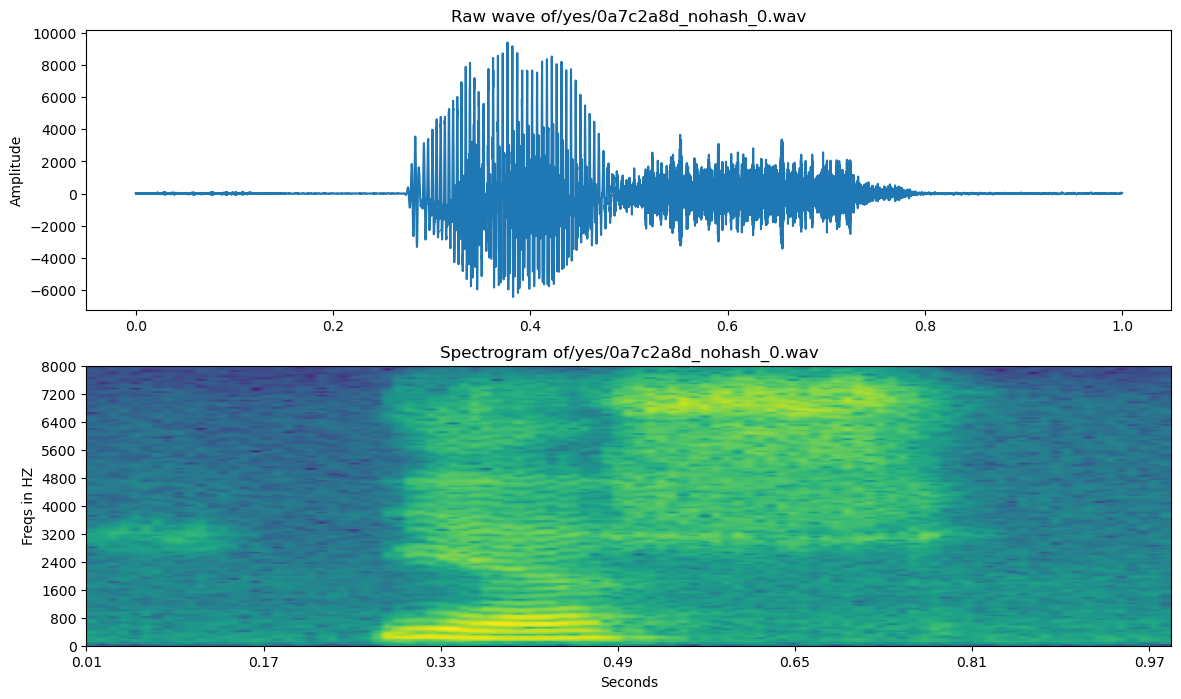

In [13]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of' +filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of'+ filename)
ax2.set_ylabel('Freqs in HZ')
ax2.set_xlabel("Seconds")

If we use spectrogram as an input features for NN, we have to remember to normalize features.(We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)

우리가 만약 인풋으로 스펙토그램을 사용한다면 꼭 정규화를 기억해야 한다.(좋은 std와 mean을 구하기 위해서는 모든 데이터셋에 대한 전반적인 정규화가 필요하다.)

In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50Hz. However, frequency resolutuin of the ear is 3.6Hz within the octave of 1000-2000 Hz it means, that people are far more precise ad can hear much smaller details than those represented by spectrograms like above.
```
(각 프레임에 ~160개의 특징이 있으며, 주파수는 0~8000사이이다. 그것은 하나의 특징이 50Hz에 해당한다는 것을 의미한다. 귀의 가청주파수 영역은 3.6hz(1000~2000Hz 옥타브내에서)이다. 이 뜻은 스펙트로그램으로 표시된 것보다 훨씬 더 정확한 디테일들을 사람이 들을 수 있다는 것을 의미한다.
```

# 1.2 MFCC
If you want to get to know some details about MFCC take a look at this great tutorial. MFCC explained You can see, that it is well prepared to imitate human hearing properties.

You can calculate Mel Power Spectrogram and MFCC using for example librosa python package.

MFCC에 대해 알고싶다면 다음 챕터가 좋은 튜토리얼이 될 것이다. MFCC는 사람이 들은 것을 잘 다듬어 놓은것이다. 

파이썬 librosa패키지를 이용해서 mel power spectrogram과 mfcc를 계산 할 수 있다.

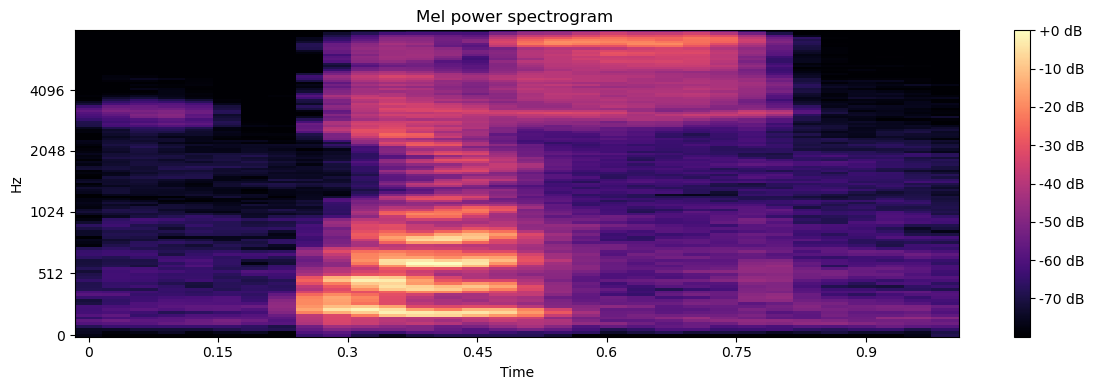

In [15]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
samples = samples.astype(np.float32) #오디오데이터는 float형태로 입력되어야 함
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

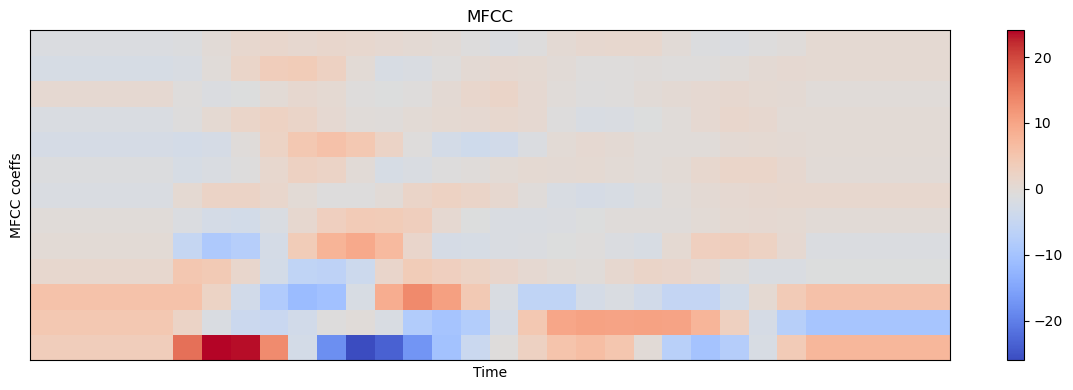

In [16]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

#let's pad on the first and secons deltas while we;re at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state of the art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.
(여전히 최신 기술 시스템에서 MFCC 또는 그와 유사한 기능은 스펙트로그램대신 시스템에 대한 입력으로 쓰인다.)

However, in end-to-end(often neural-network based)systems, the most common input features are probably raw spectrograms, or mel power spectrograms For example MFCC decorrelates features, but NNs deal with correlated features well.
Also, if you'll understand mel filters, you may consider their usage sensible.a
(하지만 종종 종단간 시스템에서 가장 일반적인 입력기능은 raw 스펙트로그램과 멜파워 스펙트로그램 일 수 있다. 예를 들어, MFCC는 특징과 상관 관계가 없지만 NNs는 피쳐와 상관관계가 있는 기능을 잘 처리한다. 멜필터를 이해하고 있다면, 사용하는것을 고려해도 좋다.)
it is your decision which to choose
(

# 1.3. Spetrogram in 3D
By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

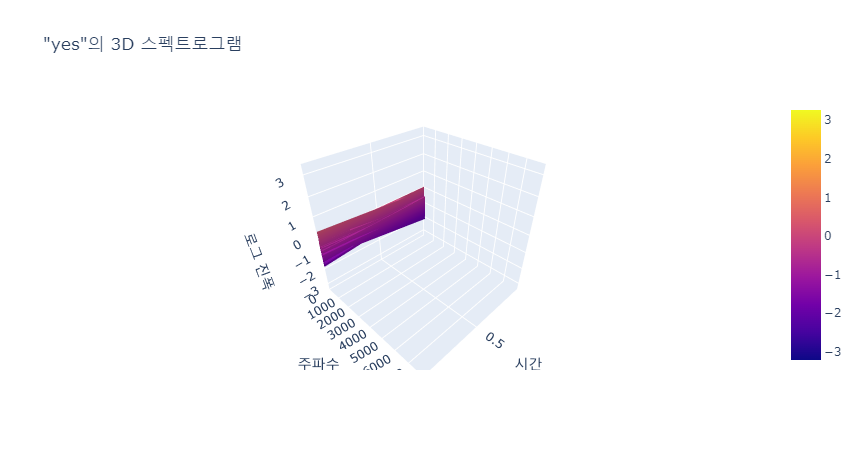

In [17]:

data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='"yes"의 3D 스펙트로그램',
    scene=dict(
        yaxis=dict(title='주파수', range=[freqs.min(), freqs.max()]),
        xaxis=dict(title='시간', range=[times.min(), times.max()]),  # x축 범위 수정
        zaxis=dict(title='로그 진폭'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


# 1.4. Silence removal

Let's listen to that file

In [18]:
ipd.Audio(samples, rate=sample_rate)

I consider that some VAD(voice activity detection) will be really useful here.
Although the words are short, there is a lot of silence in them. A decent VAD can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the fule from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [19]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

we can agree that the entire word can be heard. it is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example webrtcvad package to have a good VAD.

Let's plot it again, together with guessed alignment of 'y','e','s' graphems

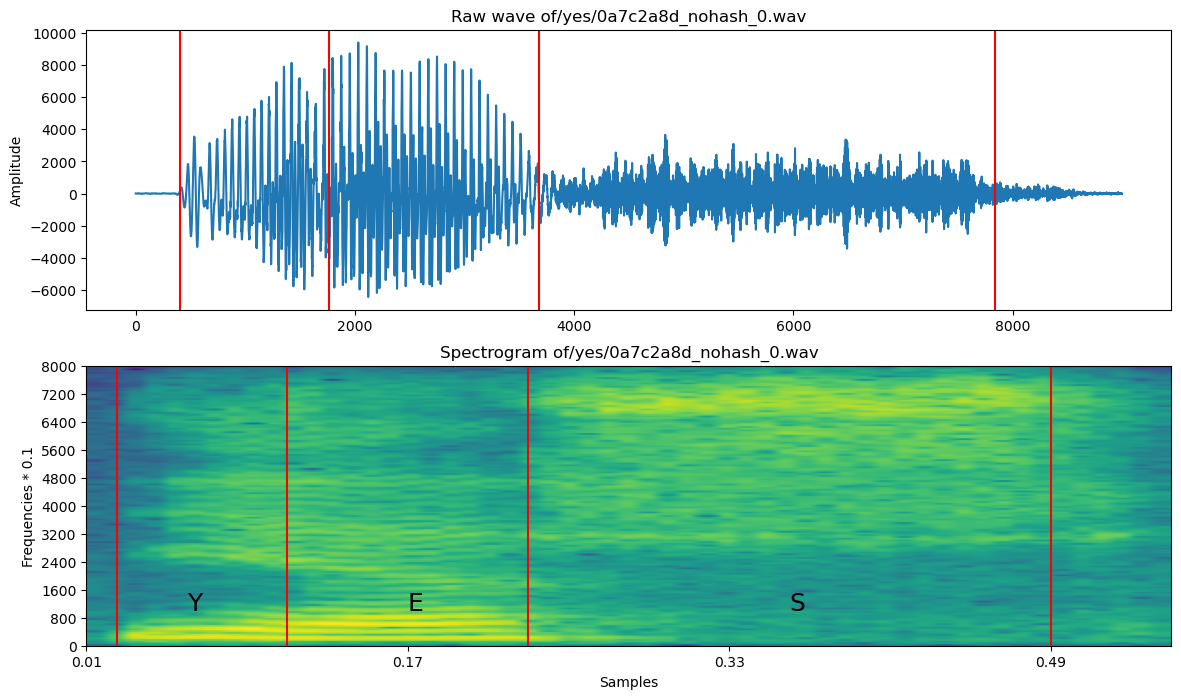

In [20]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of'+ filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of'+ filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')


# 1.5. Resampling - dimensionality reduction
Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more, However, the most speech related frequencies are preseneted in smaller band. That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the ohter hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT(퓨리에변환)

In [21]:
def custom_fft(y,fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2]) 
    return xf, vals

Let's read some recording, resample it. and listen. We can also compare FFT, Notice, that there is almost no information above 4000Hz in original signal.

In [22]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [23]:
ipd.Audio(samples, rate = sample_rate)

In [24]:
ipd.Audio(resampled, rate=new_sample_rate)

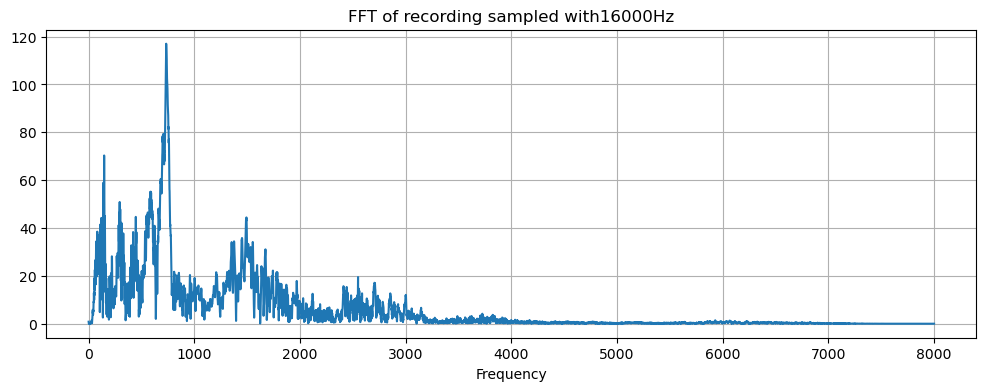

In [25]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with'+ str(sample_rate)+ 'Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

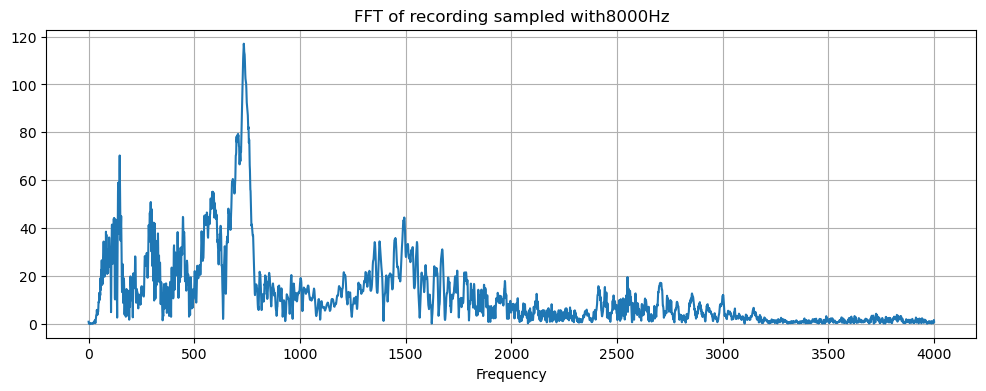

In [26]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with'+ str(new_sample_rate)+ 'Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!

# 1.6 Features extraction steps
I would propose the feature extraction algorithm like that:

1. Resampling
2. VAD
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or MFCC, or PLP)
5. Features normalization with mean and std
6. Stacking of a given anumber of frames to get temporal infomation

It's a pity it can't be done in notebook. It has not nuch sense to write things from zerom and 
everyrhing is readt to take, but in packages, that can not be imported in Kernels.

# 2. Dataset investigation
Some usuall investigation of dataset.

# 2.1 Number of records

In [29]:
dirs= [ f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path,f))]
dirs.sort()
print('Number of labels:' + str(len(dirs)))  

Number of labels:31


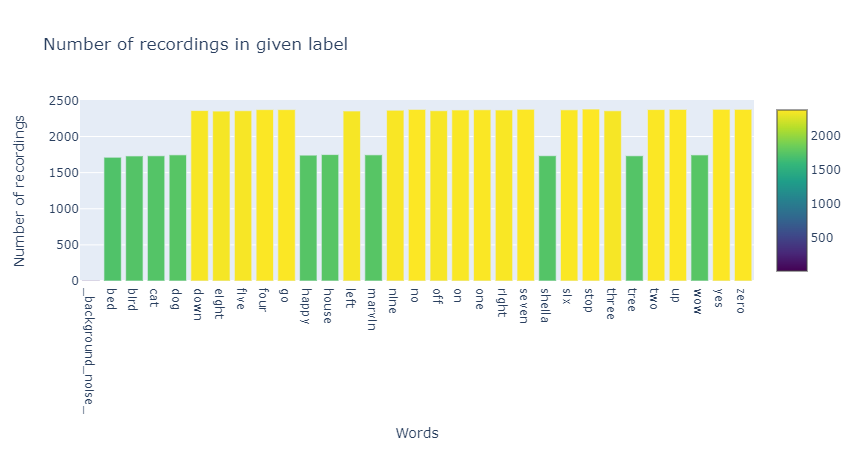

In [36]:
# calculate

number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

#plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
x=dirs,
y=number_of_recordings,
marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True),
)
layout = go.Layout(
title = 'Number of recordings in given label',
xaxis = dict(title='Words'),
yaxis = dict(title='Number of recordings'))

py.iplot(go.Figure(data=[trace], layout=layout))

Dataset is balanced except of backgrouns_noise, but that's the different thing.

## 2.2 Deeper into recordings

There's a very important fact. Recordins come from very different sources. As far as I can tell, some of them can come from  mobile GSM channel.

Nevertheless, it is extrmely important to split the dataset in a way that one speaker doesn't occur in both train and test sets. Just take a look and listen to this two examples:

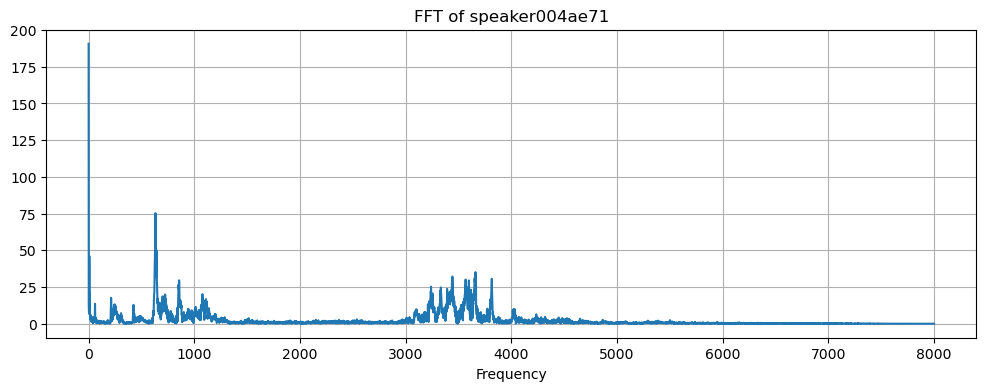

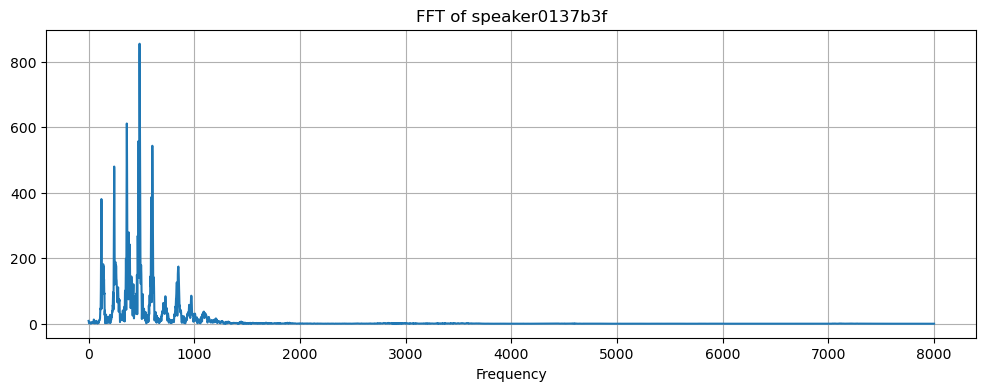

In [38]:
filenames = ['/on/004ae714_nohash_0.wav', '/on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12,4))
    plt.title('FFT of speaker' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()


Even better to listen:

In [ ]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0])) 

print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

#on 음성파일 불러오기 코드인데 실행 오류가 계속 나서 일단 뛰어넘기로

There are also recordings with some weird silence (some compression?):

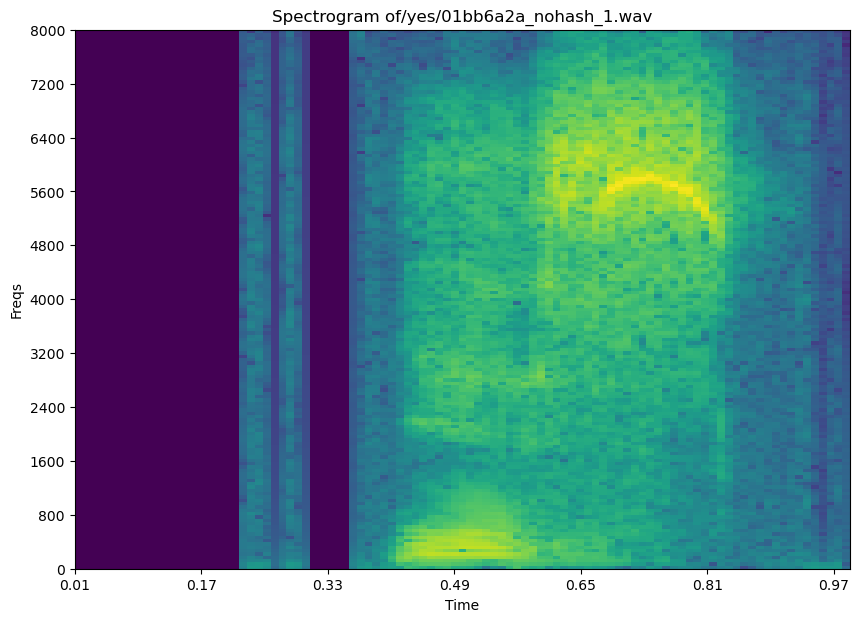

In [44]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize = (10,7))
plt.title('Spectrogram of' +filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T , aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical enviroments.

## 2.3 Recordings length

Find if all the files have 1 second duration:

In [46]:
num_of_shorters = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        file_path = join(train_audio_path, direct, wav)  # 파일 경로 생성
        sample_rate, samples = wavfile.read(file_path)
        if samples.shape[0] < sample_rate:
            num_of_shorters += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorters))


/tmp/ipykernel_32/2240365000.py:6: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


That's suprisingm and there is a lot of them. We can pad them with zeros.

## 2.4 Mean spevtrograms and FFT

let's plot mean FFT for every word

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


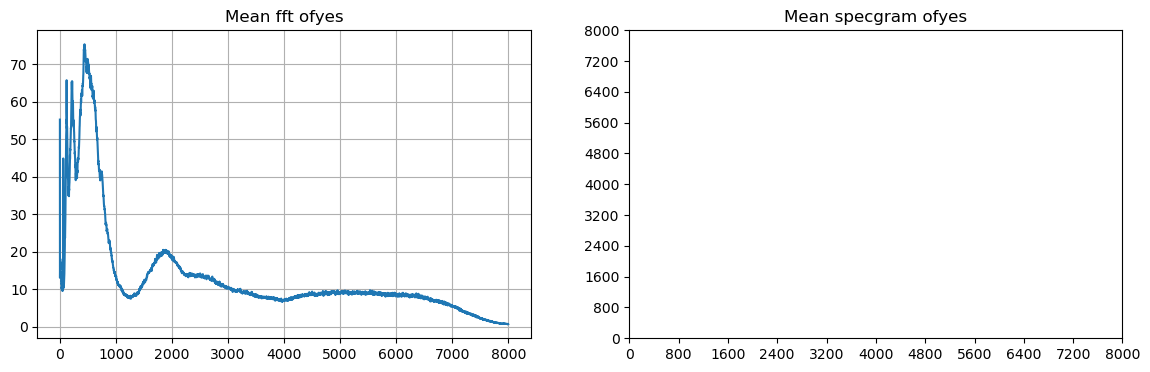

In [48]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []
    
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        file_path = join(train_audio_path, direct, wav)  # 파일 경로 생성
        sample_rate, samples = wavfile.read(file_path)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)
        
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Mean fft of' + direct)
plt.plot(np.mean(np.array(vals_all), axis =0))
plt.grid()
plt.subplot(122)
plt.title('Mean specgram of' + direct)
plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect = 'auto', origin = 'lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(freqs[::16])
plt.show()

## 2.5 Gaussian Mixtures modeling
We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like stop and up... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of stop(probably s).

That's why temporal component is also necessary. There is a Kaldi library, that can model words(or smaller parts of words) with GMMs and model temporal dependencies with Hidden Markov Models.

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use 싸이킷런 for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6 Frequeny componenets across the words

In [64]:
def violinplot_frequency(dirs, freq_ind):
    spec_all = []
    
    for direct in dirs:
        spec_direct = []
        
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves[:100]:
            file_path = join(train_audio_path, direct, wav)
            sample_rate, samples = wavfile.read(file_path)
            freqs, times, spec = log_specgram(samples, sample_rate)
            if freq_ind < len(freqs):
                spec_direct.append(spec[:, freq_ind])
        
        spec_all.extend(spec_direct)
    
    # Make the number of frames equal
    min_len = min([len(spec) for spec in spec_all])
    spec_all = [spec[:min_len] for spec in spec_all]
    
    plt.figure(figsize=(13, 7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + 'Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all, columns=range(min_len)))
    plt.show()


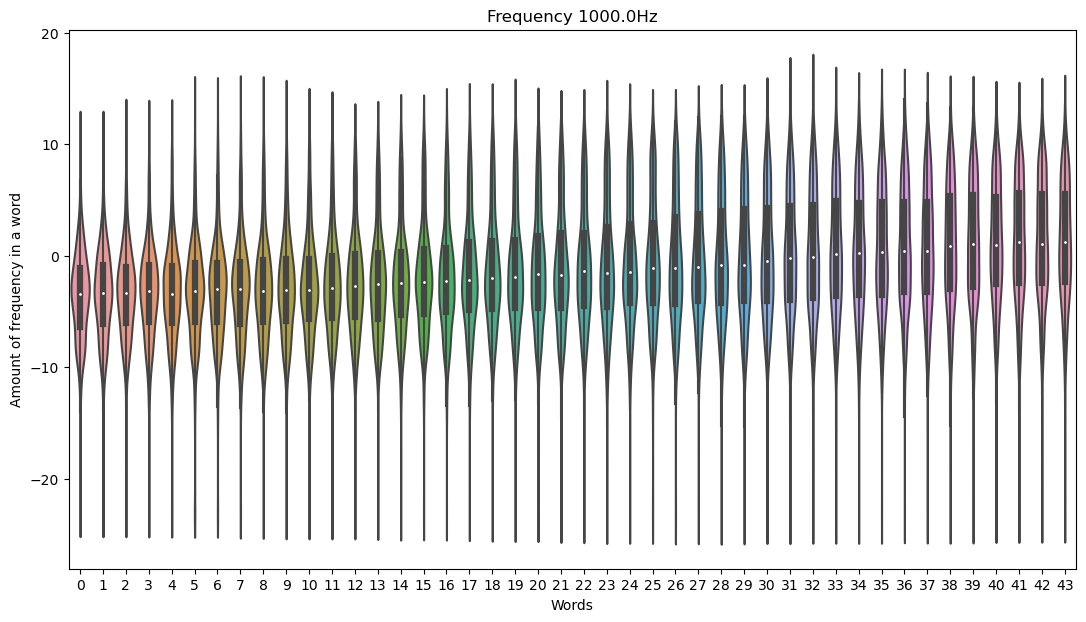

In [65]:
violinplot_frequency(dirs, 20)

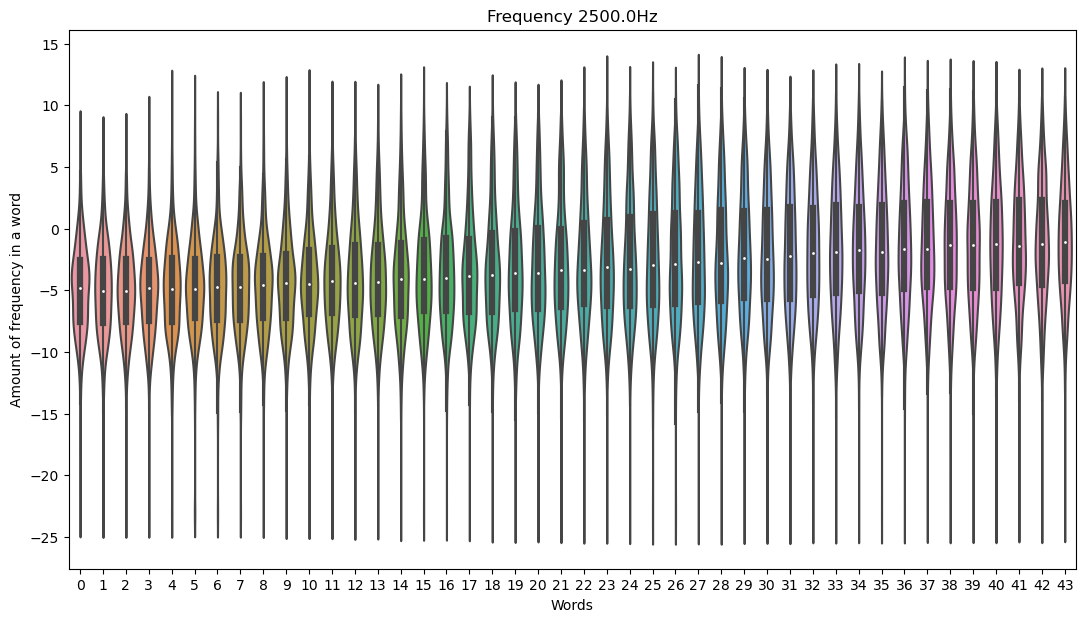

In [60]:
violinplot_frequency(dirs,50)

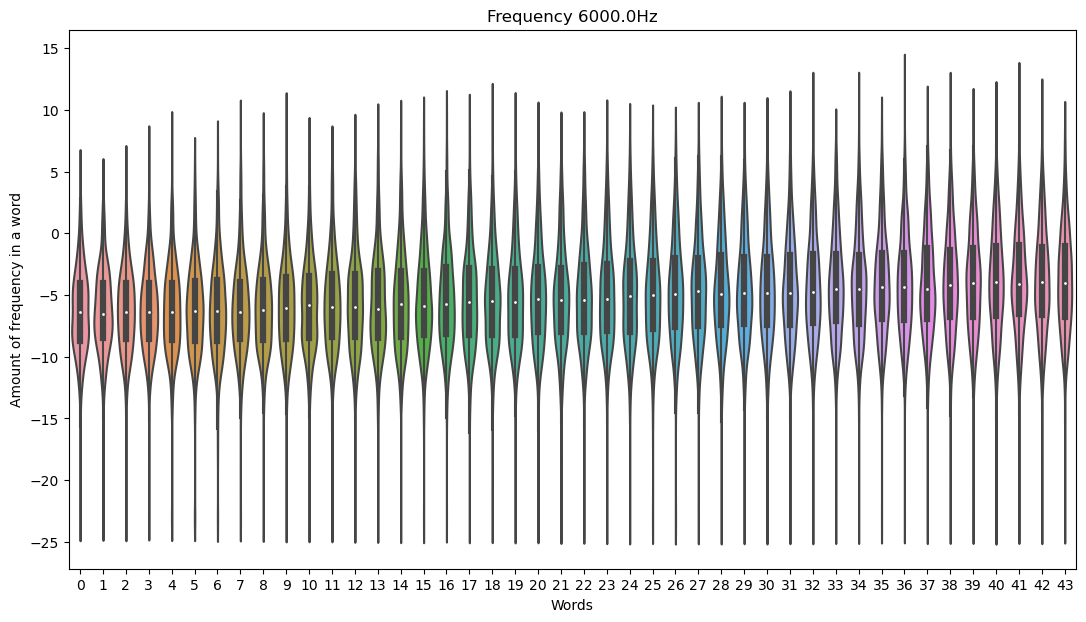

In [61]:
violinplot_frequency(dirs,120)

## 2.7 Anomaly detection
We should check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality. the dataset and interactively check for any anomaly. We'll use PCA for dimensionality reduction:

/opt/conda/lib/python3.10/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




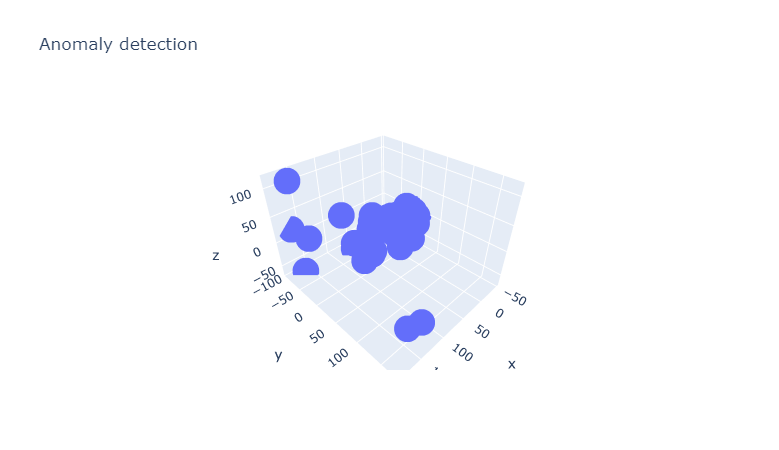

In [67]:
fft_all = []
names = []
for direct in dirs:
        spec_direct = []
        
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves[:100]:
            file_path = join(train_audio_path, direct, wav)
            sample_rate, samples = wavfile.read(file_path)
            if samples.shape[0] != sample_rate:
                samples = np.append(samples, np.zeros((sample_rate - samples.shape[0],)))
                x, val =custom_fft(samples, sample_rate)
                fft_all.append(val)
                names.append(direct + '/' + wav)
                
fft_all = np.array(fft_all)

#정규화
fft_all = (fft_all -np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

#din reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2], mode='markers',
                        text=names)
    data = go.Data([scatt])
    layout = go.Layout(title='Anomaly detection')
    figure = go.Figure(data=data, layout= layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

Notice that there are yes/~wav, go/~wav and more points, that lie far away from the rest .Let;s listen to them.